# Prediction of energy consumption 

## Importing packages and reading data

In [195]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
from sklearn.preprocessing import LabelBinarizer,RobustScaler, StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, ElasticNet, Ridge
from sklearn.svm import LinearSVR

data = pd.read_csv("data\Steel_industry_data.csv")

## Data preprocessing and analysis

Data preview

In [196]:
data.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


Shape of data

In [197]:
data.shape

(35040, 11)

### Information about the dataset

Description of variables:
| **Variable**                    | **Type**    | **Measurement**                       |
|---------------------------------|-------------|---------------------------------------|
| Industry Energy Consumption     | Continuous  | kWh                                   |
| Lagging Current reactive power  | Continuous  | kVarh                                 |
| Leading Current reactive power  | Continuous  | kVarh                                 |
| tCO2(CO2)                       | Continuous  |  ppm                                  |
| Lagging Current power factor    | Continuous  | %                                     |
| Leading Current Power factor    | Continuous  | %                                     |
| Number of Seconds from midnight | Continuous  | s                                     |
| Week status                     | Categorical | Weekend (0) or a Weekday(1)           |
| Day of week                     | Categorical | Sunday, Monday...Saturday             |
| Load Type                       | Categorical | Light Load, Medium Load, Maximum Load |
|                                 |             |                                       |

In [198]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

### Checking missing values

In [199]:
data.isnull().sum()

date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
dtype: int64

### Identify duplicates

In [200]:
dups = data.duplicated()
data[dups]

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type


### Identify mistyped data

Check numeric

In [201]:
numeric = data.applymap(lambda x: isinstance(x, (int, float)))['Usage_kWh']
data[~numeric]

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type


Check string

In [202]:
strings = data.applymap(lambda x: isinstance(x, (str)))['Day_of_week']
data[~strings]

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type


### Columns info

Column 'WeekStatus' values:

In [203]:
data['WeekStatus'].value_counts()

Weekday    25056
Weekend     9984
Name: WeekStatus, dtype: int64

Column 'Load_Type' values:

In [204]:
data['Load_Type'].value_counts()

Light_Load      18072
Medium_Load      9696
Maximum_Load     7272
Name: Load_Type, dtype: int64

Mean value

In [205]:
data.mean(numeric_only=True)

Usage_kWh                                  27.386892
Lagging_Current_Reactive.Power_kVarh       13.035384
Leading_Current_Reactive_Power_kVarh        3.870949
CO2(tCO2)                                   0.011524
Lagging_Current_Power_Factor               80.578056
Leading_Current_Power_Factor               84.367870
NSM                                     42750.000000
dtype: float64

Median value

In [206]:
data.median(numeric_only=True)

Usage_kWh                                   4.57
Lagging_Current_Reactive.Power_kVarh        5.00
Leading_Current_Reactive_Power_kVarh        0.00
CO2(tCO2)                                   0.00
Lagging_Current_Power_Factor               87.96
Leading_Current_Power_Factor              100.00
NSM                                     42750.00
dtype: float64

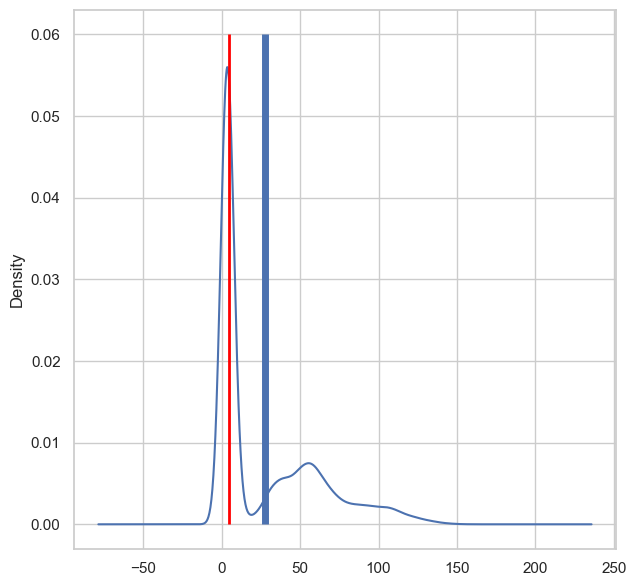

In [207]:
data['Usage_kWh'].plot(kind="density", figsize=(7,7))
plt.vlines(data['Usage_kWh'].mean(), ymin = 0, ymax = 0.06, linewidth = 5.0)
plt.vlines(data['Usage_kWh'].median(), ymin=0, ymax=0.06, linewidth=2.0, color="red")

Mode value

In [208]:
data.mode()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:00,3.06,0.0,0.0,0.0,100.0,100.0,0.0,Weekday,Monday,Light_Load
1,01/01/2018 00:15,NaN,NaN,NaN,NaN,NaN,NaN,900.0,NaN,NaN,NaN
2,01/01/2018 00:30,NaN,NaN,NaN,NaN,NaN,NaN,1800.0,NaN,NaN,NaN
3,01/01/2018 00:45,NaN,NaN,NaN,NaN,NaN,NaN,2700.0,NaN,NaN,NaN
4,01/01/2018 01:00,NaN,NaN,NaN,NaN,NaN,NaN,3600.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
35035,31/12/2018 22:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35036,31/12/2018 23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35037,31/12/2018 23:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35038,31/12/2018 23:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Variance

In [209]:
data['Usage_kWh'].var()

1118.5265340538938

Standard deviation

In [210]:
data['Usage_kWh'].std()

33.44437970801513

Percentiles

In [211]:
percentiles = np.percentile(data['Usage_kWh'], [0, 25, 50, 75, 100])
percentiles

array([  0.    ,   3.2   ,   4.57  ,  51.2375, 157.18  ])

'Usage_kWh' column description:

In [212]:
desc_stat = scipy.stats.describe(data['Usage_kWh'], ddof = 1, bias = False)
desc_stat

DescribeResult(nobs=35040, minmax=(0.0, 157.18), mean=27.386892408675795, variance=1118.526534053894, skewness=1.1973938227692211, kurtosis=0.3913856014239281)

Data description

In [213]:
data.describe()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


Usage_kWh vs Day of Week

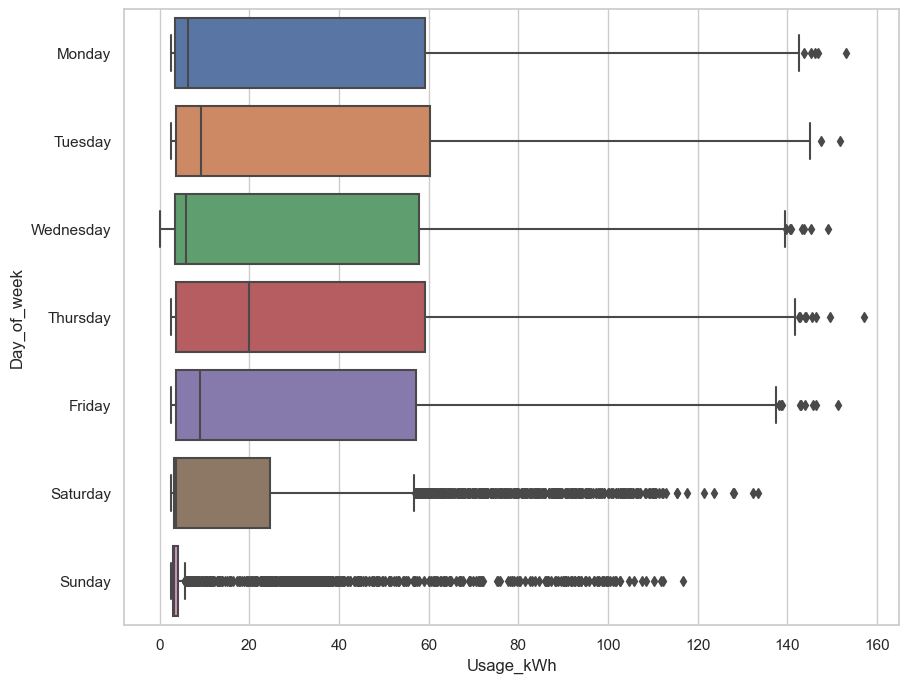

In [214]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,8))
ax = sns.boxplot(x='Usage_kWh', data=data, y='Day_of_week', orient="h")

Correlation map

In [215]:
# correlation = data.corr(numeric_only=True)
# plt.figure(figsize=(7,7))
# sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')


Day of Week

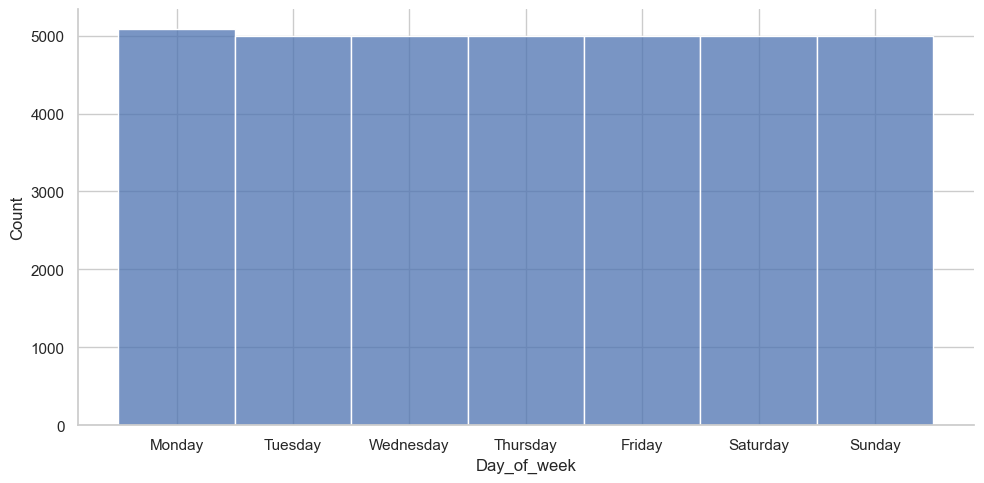

In [216]:
sns.displot(data['Day_of_week'], height=5, aspect=2)

Boxplots

{'whiskers': [<matplotlib.lines.Line2D at 0x2c9a5361330>,
 'caps': [<matplotlib.lines.Line2D at 0x2c9a5362740>,
 'boxes': [<matplotlib.lines.Line2D at 0x2c9a5363070>,
 'medians': [<matplotlib.lines.Line2D at 0x2c9a5361fc0>,
 'fliers': [<matplotlib.lines.Line2D at 0x2c9a5361cc0>,
 'means': []}

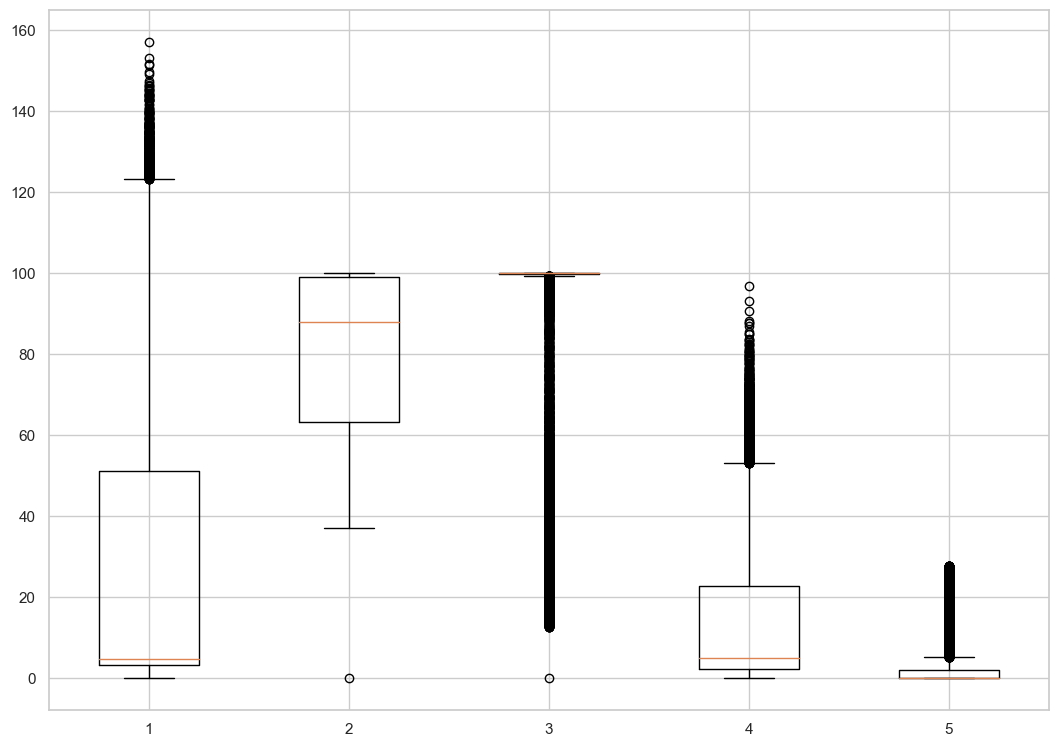

In [217]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot([data['Usage_kWh'], data['Lagging_Current_Power_Factor'], data['Leading_Current_Power_Factor'], data['Lagging_Current_Reactive.Power_kVarh'], data['Leading_Current_Reactive_Power_kVarh']])

### Feature Engineering

Encoding Nominal Categorial Data

In [218]:
one_hot = LabelBinarizer()

encoded_weekstatus = one_hot.fit_transform(data['WeekStatus'])
data['WeekStatus'] = one_hot.fit_transform(data['WeekStatus'])
print(one_hot.classes_)
print(encoded_weekstatus)

encoded_load_type = one_hot.fit_transform(data['Load_Type'])
data['Load_Type'] = one_hot.fit_transform(data['Load_Type'])

print(one_hot.classes_)
encoded_load_type

['Weekday' 'Weekend']
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
['Light_Load' 'Maximum_Load' 'Medium_Load']


array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

Encoding Ordinal Categorial Data

In [219]:
scale_mapper = {"Monday": 1,
                "Tuesday": 2,
                "Wednesday": 3,
                "Thursday": 4,
                "Friday": 5,
                "Saturday": 6,
                "Sunday": 7}

encoded_day_of_week = data['Day_of_week'].replace(scale_mapper)
data['Day_of_week'] = data['Day_of_week'].replace(scale_mapper)

print(data['Day_of_week'].value_counts())
#encoded_day_of_week.value_counts()

1    5088
2    4992
3    4992
4    4992
5    4992
6    4992
7    4992
Name: Day_of_week, dtype: int64


Correlation map after encoding categorical data

In [220]:
# correlation = data.corr(numeric_only=True)
# plt.figure(figsize=(7,7))
# sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8})

In [221]:
data = data.loc[:, data.columns != 'date']

## Model building and Evaluation

### Testing different Regression Models with all features

In [222]:
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=0)

training_score = []

dummy = DummyRegressor(strategy="mean")
dummy.fit(features_train, target_train)
d_score = dummy.score(features_test, target_test)


clf = DummyRegressor(strategy='constant', constant=20)
clf.fit(features_train, target_train)
clf_score = clf.score(features_train, target_train)

lr = LinearRegression()
lr.fit(features_train, target_train)

training_score.append(lr.score(features_train, target_train))

lasso = Lasso(alpha=0.1)
lasso.fit(features_train, target_train)

training_score.append(lasso.score(features_train, target_train))

en = ElasticNet(alpha=0.1)
en.fit(features_train, target_train)

training_score.append(en.score(features_train, target_train))

rlr = Ridge(alpha=0.1)
rlr.fit(features_train, target_train)

training_score.append(rlr.score(features_train, target_train))

scaler = MinMaxScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)
svr_max_scaler = LinearSVR()
svr_max_scaler.fit(features_train, target_train)

training_score.append(svr_max_scaler.score(features_train, target_train))

scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)
svr_standard_scaler = LinearSVR()
svr_standard_scaler.fit(features_train, target_train)

training_score.append(svr_standard_scaler.score(features_train, target_train))


In [223]:
def show_results(score_list: list, labels: list):
    train_score = pd.DataFrame(data = score_list, columns = ['Training_R2'])
    train_score.index = labels
    train_score = (train_score * 100).round(4)
    plt.xticks(rotation=90)
    plt.grid(visible=None)
    plt.scatter(x=train_score.index, y=train_score['Training_R2'], c=train_score['Training_R2'], cmap='Dark2_r')
    for i in range(len(train_score['Training_R2'])):
        plt.annotate(str(train_score['Training_R2'][i]), (i, train_score['Training_R2'][i]), textcoords="offset points", xytext=(0,10))

Training Score

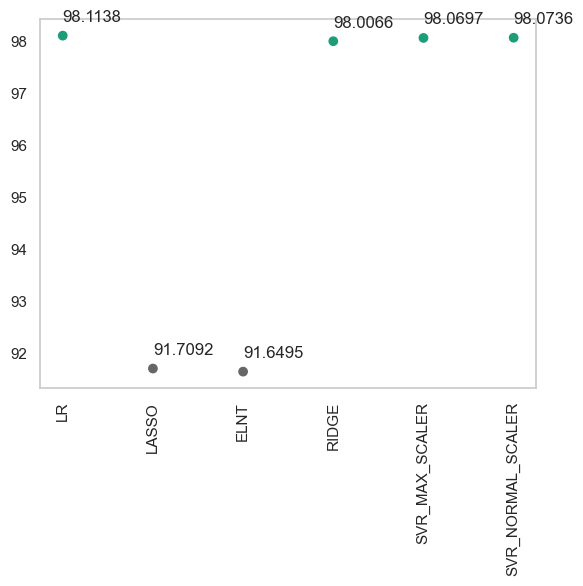

In [224]:
models = ['LR', 'LASSO', 'ELNT', 'RIDGE', 'SVR_MAX_SCALER', 'SVR_NORMAL_SCALER']
show_results(score_list=training_score, labels=models)

Describing data after removing row with all zeroes

In [225]:
data = data[data['Usage_kWh'] != 0]

data.describe()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
count,35039.000000,35039.000000,35039.000000,35039.000000,35039.000000,35039.000000,35039.000000,35039.000000,35039.000000,35039.000000
mean,27.387674,13.035756,3.871059,0.011525,80.580356,84.370278,42751.220069,0.284940,3.991809,0.515740
std,33.444537,16.306084,7.424540,0.016151,18.916695,30.453634,24939.844508,0.451392,2.003455,0.499759
min,2.450000,0.000000,0.000000,0.000000,36.940000,12.500000,0.000000,0.000000,1.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21600.000000,0.000000,2.000000,0.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,43200.000000,0.000000,4.000000,1.000000
75%,51.245000,22.640000,2.090000,0.020000,99.025000,100.000000,64350.000000,1.000000,6.000000,1.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000,1.000000,7.000000,1.000000


### Different Scalers for Linear Regression

In [226]:
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=0)

testing_score = []
scaler = RobustScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)
model = LinearRegression()
model.fit(features_train, target_train)
testing_score.append(model.score(features_test, target_test))

scaler = MinMaxScaler()
X_train = scaler.fit_transform(features_train)
X_test = scaler.transform(features_test)
model = LinearRegression()
model.fit(features_train, target_train)
testing_score.append(model.score(features_test, target_test))

scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)
model = LinearRegression()
model.fit(features_train, target_train)
testing_score.append(model.score(features_test, target_test))

nof_list=np.arange(1,9)
high_score=0

Score of LR Models with different scalers

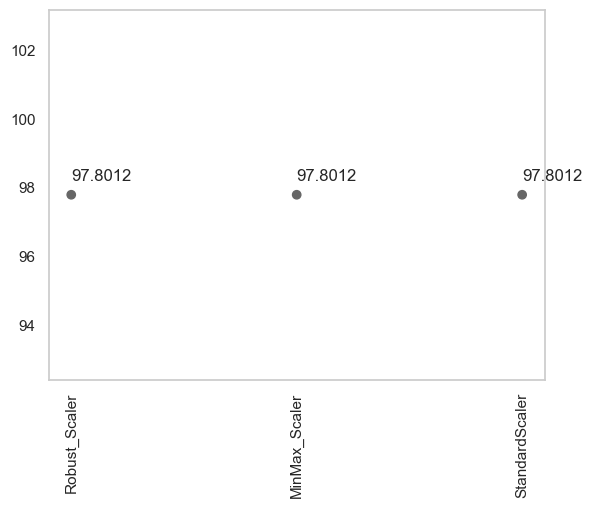

In [227]:
labels = ['Robust_Scaler', 'MinMax_Scaler', 'StandardScaler']
show_results(score_list=testing_score, labels=labels)

<h3>RFE Method for Feature Selection</h3>

In [228]:
def rfe_method(model):
    nof_list=np.arange(1,9)            
    high_score=0

    nof=0           
    score_list =[]
    for n in range(len(nof_list)):
        features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
        features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

        rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
        features_train_rfe = rfe.fit_transform(features_train,target_train)
        features_test_rfe = rfe.transform(features_test)
        model.fit(features_train_rfe, target_train)
        score = model.score(features_test_rfe, target_test)
        score_list.append(score)
        if(score>high_score):
            high_score = score
            nof = nof_list[n]
    print("Optimum number of features: %d" %nof)
    print("Score with %d features: %f" % (nof, high_score))

    features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
    cols = list(features.columns)
    rfe = RFE(estimator=model, n_features_to_select=nof)             
    rfe = rfe.fit(features, target)  
    print(rfe.get_feature_names_out())
    return features[features.columns[rfe.support_]]

<h3>Grid Search for Hyperparameters</h3>

In [229]:
def gridsearch(model, space, scoring='neg_mean_absolute_error', cv=10, scaler=None):
    features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

    if scaler is not None:
        features_train = scaler.fit_transform(features_train)

    grid_search = GridSearchCV(model, space, scoring=scoring, n_jobs=-1, cv=cv)
    grid_result = grid_search.fit(features_train, target_train)
    
    print('Grid Search - Best Score: %s' % grid_result.best_score_)
    print('Grid Search - Best Hyperparameters: %s' % grid_result.best_params_)
    return grid_result.best_params_

<h3>Random Search for Hyperparameters</h3>

In [230]:
def randomsearch(model, space, scoring='neg_mean_absolute_error', scaler=None):
    features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

    if scaler is not None:
        features_train = scaler.fit_transform(features_train)
        
    randomized_search = RandomizedSearchCV(model, space, scoring=scoring)
    randomized_result = randomized_search.fit(features_train, target_train)
    print('Randomized Search - Best Score: %s' % randomized_result.best_score_)
    print('Randomized Search - Best Hyperparameters: %s' % randomized_result.best_params_)
    return randomized_result.best_params_

In [231]:
def visualize_model(x, y, title):
    plt.title(title)
    plt.plot(x, y, 'o', color='r')

    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m * x + b, color = 'darkblue')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

In [232]:
training_score = []
testing_score = []

<h3>Linear Regression</h3>

Grid Search - Best Score: -2.530877780960384
Grid Search - Best Hyperparameters: {'fit_intercept': True}
Randomized Search - Best Score: -2.5302369926711483
Randomized Search - Best Hyperparameters: {'fit_intercept': True}


d:\Programs\Python\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Optimum number of features: 8
Score with 8 features: 0.978820
['Lagging_Current_Reactive.Power_kVarh'
 'Leading_Current_Reactive_Power_kVarh' 'CO2(tCO2)'
 'Lagging_Current_Power_Factor' 'Leading_Current_Power_Factor'
 'WeekStatus' 'Day_of_week' 'Load_Type']
The train score for LR model is 0.9810272405473877
The test score for LR model is 0.978820020013351


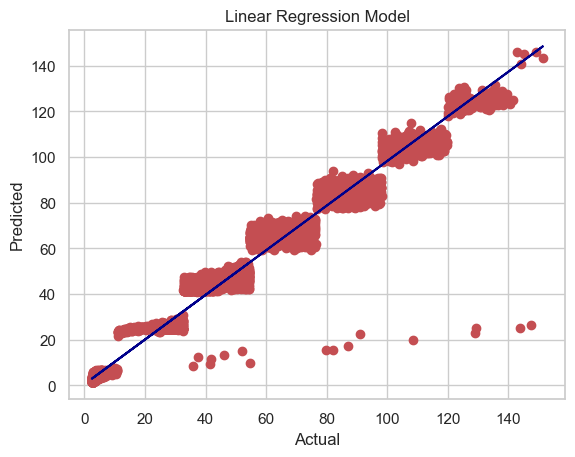

In [233]:
model = LinearRegression()

space = dict()
space['fit_intercept'] = [True, False]
hyperparams_gridsearch = gridsearch(model, space)
hyperparams_randomsearch = randomsearch(model, space)

if hyperparams_gridsearch['fit_intercept'] == hyperparams_randomsearch['fit_intercept']:
    model.fit_intercept = hyperparams_gridsearch['fit_intercept']

    selected_features = rfe_method(model)

    features, target = selected_features, data['Usage_kWh']
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

    model.fit(features_train, target_train)
    train_score = model.score(features_train, target_train)
    test_score = model.score(features_test, target_test)

    print("The train score for LR model is {}".format(train_score))
    print("The test score for LR model is {}".format(test_score))
else:
    model.fit_intercept = hyperparams_gridsearch['fit_intercept']

    selected_features = rfe_method(model)

    features, target = selected_features, data['Usage_kWh']
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

    model.fit(features_train, target_train)
    train_score = model.score(features_train, target_train)
    test_score = model.score(features_test, target_test)

    print("GridSearch: The train score for LR model is {}".format(train_score))
    print("GridSearch: The test score for LR model is {}".format(test_score))

    model.fit_intercept = hyperparams_randomsearch['fit_intercept']

    selected_features = rfe_method(model)

    features, target = selected_features, data['Usage_kWh']
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

    model.fit(features_train, target_train)
    train_score = model.score(features_train, target_train)
    test_score = model.score(features_test, target_test)

    print("RandomSearch: The train score for LR model is {}".format(train_score))
    print("RandomSearch: The test score for LR model is {}".format(test_score))

training_score.append(train_score)
testing_score.append(test_score)

predicted = model.predict(features_test)

visualize_model(target_test, predicted, "Linear Regression Model")

<h3>Ridge Regression</h3>

Grid Search - Best Score: -2.5311496940872344
Grid Search - Best Hyperparameters: {'alpha': 0.0001, 'fit_intercept': True, 'solver': 'svd'}
Optimum number of features: 8
Score with 8 features: 0.978820
['Lagging_Current_Reactive.Power_kVarh'
 'Leading_Current_Reactive_Power_kVarh' 'CO2(tCO2)'
 'Lagging_Current_Power_Factor' 'Leading_Current_Power_Factor'
 'WeekStatus' 'Day_of_week' 'Load_Type']
The train score for ridge model (alpha=0.0001) is 0.9810272389259522
The test score for ridge model (alpha=0.0001) is 0.9788204516050691


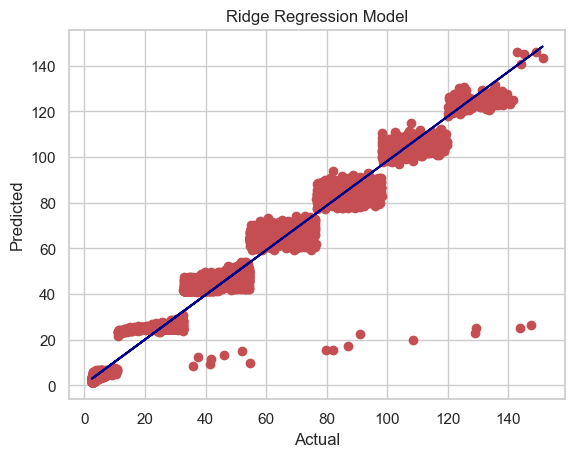

In [234]:
model = Ridge()

space = dict()
space['solver'] = ['svd', 'lsqr', 'sag']
space['alpha'] = [0.0001, 0.001, 0.01, 0.1, 1, 10]
space['fit_intercept'] = [True, False]
hyperparams_gridsearch = gridsearch(model, space)

model.fit_intercept = hyperparams_gridsearch['fit_intercept']
model.alpha = hyperparams_gridsearch['alpha']
model.solver = hyperparams_gridsearch['solver']

selected_features = rfe_method(model)

features, target = selected_features, data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

model.fit(features_train, target_train)
train_score = model.score(features_train, target_train)
test_score = model.score(features_test, target_test)

print("The train score for ridge model (alpha=" + str(model.alpha) + ") is {}".format(train_score))
print("The test score for ridge model (alpha=" + str(model.alpha) + ") is {}".format(test_score))

training_score.append(train_score)
testing_score.append(test_score)

predicted = model.predict(features_test)

visualize_model(target_test, predicted, "Ridge Regression Model")

<h3>Lasso Regression</h3>

Grid Search - Best Score: -2.5344333564492594
Grid Search - Best Hyperparameters: {'alpha': 0.0001, 'fit_intercept': True}
Optimum number of features: 8
Score with 8 features: 0.978826
['Lagging_Current_Reactive.Power_kVarh'
 'Leading_Current_Reactive_Power_kVarh' 'CO2(tCO2)'
 'Lagging_Current_Power_Factor' 'Leading_Current_Power_Factor'
 'WeekStatus' 'Day_of_week' 'Load_Type']
The train score for lasso model (alpha=0.0001) is 0.9810268960946551
The test score for lasso model (alpha=0.0001) is 0.9788259551480127


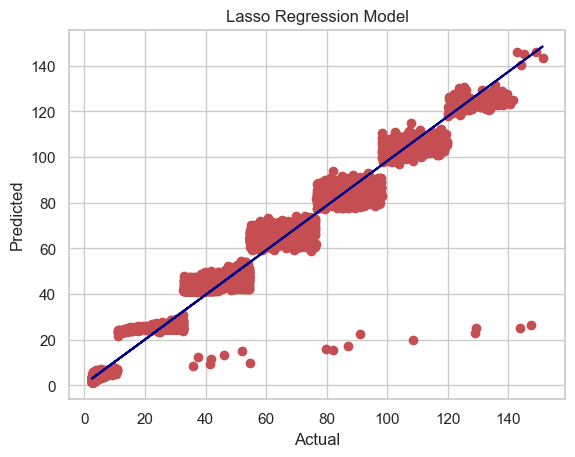

In [235]:
model = Lasso()

space = dict()
space['alpha'] = [0.0001, 0.001, 0.01, 0.1, 1, 10]
space['fit_intercept'] = [True, False]
hyperparams_gridsearch = gridsearch(model, space)

model.fit_intercept = hyperparams_gridsearch['fit_intercept']
model.alpha = hyperparams_gridsearch['alpha']

selected_features = rfe_method(model)

features, target = selected_features, data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

model.fit(features_train, target_train)
train_score = model.score(features_train, target_train)
test_score = model.score(features_test, target_test)

print("The train score for lasso model (alpha=" + str(model.alpha) + ") is {}".format(train_score))
print("The test score for lasso model (alpha=" + str(model.alpha) + ") is {}".format(test_score))

training_score.append(train_score)
testing_score.append(test_score)

predicted = model.predict(features_test)

visualize_model(target_test, predicted, "Lasso Regression Model")

<h3>ElasticNet Regression</h3>

Grid Search - Best Score: -5.1159282974895754
Grid Search - Best Hyperparameters: {'alpha': 0.0001, 'fit_intercept': False}
Optimum number of features: 3
Score with 3 features: 0.949066
['CO2(tCO2)' 'WeekStatus' 'Load_Type']
The train score for Elastic Net model (alpha=0.0001) is 0.953152632387743
The test score for Elastic Net model (alpha=0.0001) is 0.9490660893682032


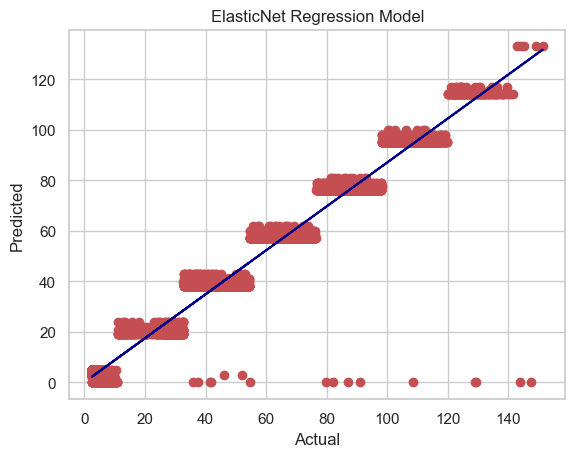

In [236]:
model = ElasticNet()

space = dict()
space['alpha'] = [0.0001, 0.001, 0.01, 0.1, 1, 10]
space['fit_intercept'] = [True, False]
hyperparams_gridsearch = gridsearch(model, space)

model.fit_intercept = hyperparams_gridsearch['fit_intercept']
model.alpha = hyperparams_gridsearch['alpha']

selected_features = rfe_method(model)

features, target = selected_features, data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

model.fit(features_train, target_train)
train_score = model.score(features_train, target_train)
test_score = model.score(features_test, target_test)

print("The train score for Elastic Net model (alpha=" + str(model.alpha) + ") is {}".format(train_score))
print("The test score for Elastic Net model (alpha=" + str(model.alpha) + ") is {}".format(test_score))

training_score.append(train_score)
testing_score.append(test_score)

predicted = model.predict(features_test)

visualize_model(target_test, predicted, "ElasticNet Regression Model")

<h3>LinearSVR</h3>
<h4>with StandardScaler</h4>

Grid Search - Best Score: -2.3770105756017528
Grid Search - Best Hyperparameters: {'C': 1, 'fit_intercept': True}


d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\P

Optimum number of features: 7
Score with 7 features: 0.901030


d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearSVR was fitted without feature names
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearSVR was fitted without feature names
  warnings.warn(


['Lagging_Current_Reactive.Power_kVarh'
 'Leading_Current_Reactive_Power_kVarh' 'CO2(tCO2)'
 'Lagging_Current_Power_Factor' 'Leading_Current_Power_Factor'
 'WeekStatus' 'Load_Type']
The train score for Linear SVR model (C=1) is 0.9806188140982306
The test score for Linear SVR model (C=1) is -75.27181922141334


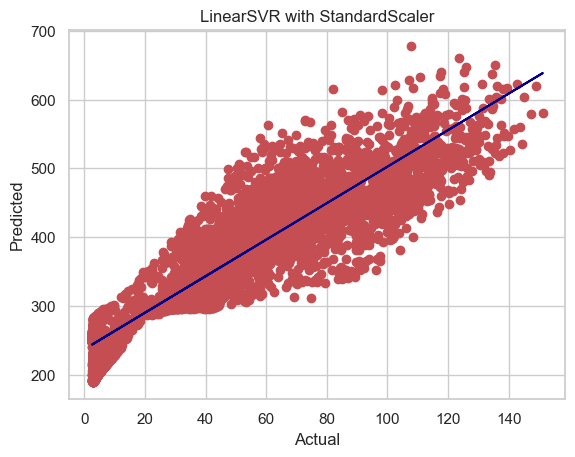

In [237]:
scaler = StandardScaler()

model = LinearSVR()

space = dict()
space['C'] = [0.1, 1, 10, 100]
space['fit_intercept'] = [True, False]
hyperparams_gridsearch = gridsearch(model, space, scaler=scaler)

model.fit_intercept = hyperparams_gridsearch['fit_intercept']
model.C = hyperparams_gridsearch['C']

selected_features = rfe_method(model)

features, target = selected_features, data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

features_train = scaler.fit_transform(features_train)

model.fit(features_train, target_train)
train_score = model.score(features_train, target_train)
test_score = model.score(features_test, target_test)

print("The train score for Linear SVR model (C=" + str(model.C) + ") is {}".format(train_score))
print("The test score for Linear SVR model (C=" + str(model.C) + ") is {}".format(test_score))

training_score.append(train_score)
testing_score.append(test_score)

predicted = model.predict(features_test)

visualize_model(target_test, predicted, "LinearSVR with StandardScaler")

<h3>LinearSVR</h3>
<h4>with MinMaxScaler</h4>

d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Grid Search - Best Score: -2.377288468813878
Grid Search - Best Hyperparameters: {'C': 10, 'fit_intercept': True}


d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\P

Optimum number of features: 1
Score with 1 features: 0.957748


d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\P

['CO2(tCO2)']
The train score for Linear SVR model (C=10) is 0.9772508270810777
The test score for Linear SVR model (C=10) is -0.31379800453057527


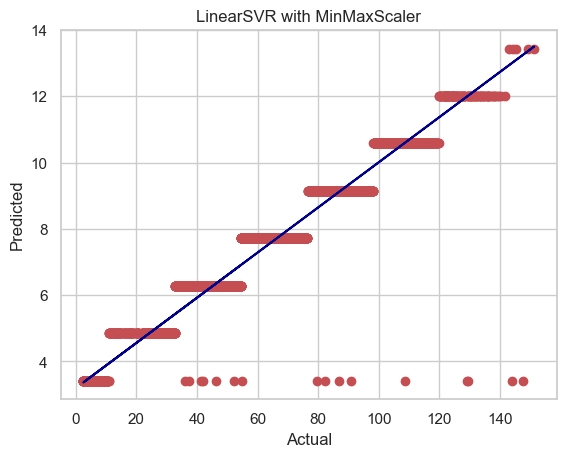

In [238]:
scaler = MinMaxScaler()

model = LinearSVR()

space = dict()
space['C'] = [0.1, 1, 10, 100]
space['fit_intercept'] = [True, False]
hyperparams_gridsearch = gridsearch(model, space, scaler=scaler)

model.fit_intercept = hyperparams_gridsearch['fit_intercept']
model.C = hyperparams_gridsearch['C']

selected_features = rfe_method(model)

features, target = selected_features, data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

features_train = scaler.fit_transform(features_train)

model.fit(features_train, target_train)
train_score = model.score(features_train, target_train)
test_score = model.score(features_test, target_test)

print("The train score for Linear SVR model (C=" + str(model.C) + ") is {}".format(train_score))
print("The test score for Linear SVR model (C=" + str(model.C) + ") is {}".format(test_score))

training_score.append(train_score)
testing_score.append(test_score)

predicted = model.predict(features_test)

visualize_model(target_test, predicted, "LinearSVR with MinMaxScaler")

<h3>LinearSVR</h3>
<h4>with RobustScaler</h4>

d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Grid Search - Best Score: -2.4308758167802234
Grid Search - Best Hyperparameters: {'C': 1, 'fit_intercept': True}


d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\P

Optimum number of features: 7
Score with 7 features: 0.905671


d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


['Lagging_Current_Reactive.Power_kVarh'
 'Leading_Current_Reactive_Power_kVarh' 'CO2(tCO2)'
 'Lagging_Current_Power_Factor' 'Leading_Current_Power_Factor'
 'WeekStatus' 'Load_Type']


d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


The train score for Linear SVR model (C=1) is 0.9034829947233589
The test score for Linear SVR model (C=1) is 0.9029290297745699


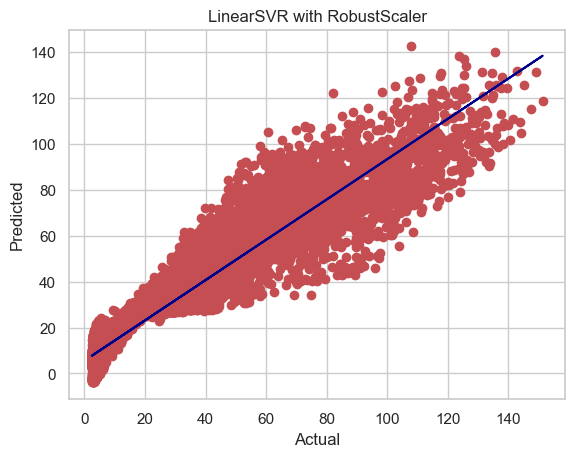

In [239]:
scaler = RobustScaler()

model = LinearSVR()

space = dict()
space['C'] = [0.1, 1, 10, 100]
space['fit_intercept'] = [True, False]
hyperparams_gridsearch = gridsearch(model, space, scaler=scaler)

model.fit_intercept = hyperparams_gridsearch['fit_intercept']
model.C = hyperparams_gridsearch['C']

selected_features = rfe_method(model)

features_train = scaler.fit_transform(features_train)

features, target = selected_features, data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

model.fit(features_train, target_train)
train_score = model.score(features_train, target_train)
test_score = model.score(features_test, target_test)

print("The train score for Linear SVR model (C=" + str(model.C) + ") is {}".format(train_score))
print("The test score for Linear SVR model (C=" + str(model.C) + ") is {}".format(test_score))

training_score.append(train_score)
testing_score.append(test_score)

predicted = model.predict(features_test)

visualize_model(target_test, predicted, "LinearSVR with RobustScaler")

<h4>Visualizing results</h4>

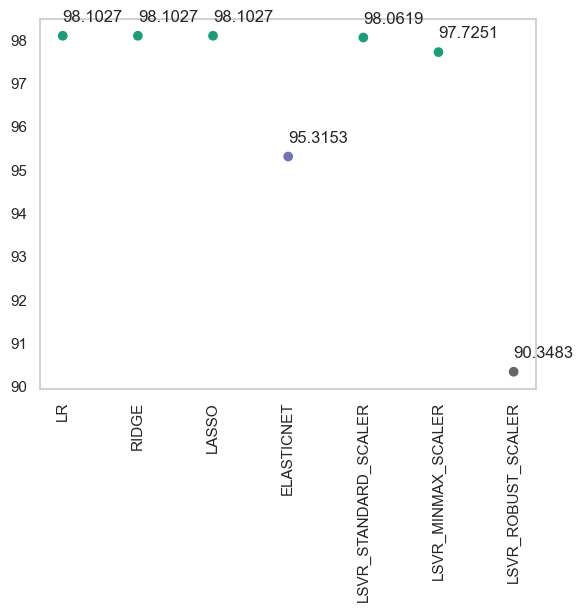

In [240]:
models = ['LR', 'RIDGE', 'LASSO', 'ELASTICNET', 'LSVR_STANDARD_SCALER', 'LSVR_MINMAX_SCALER', 'LSVR_ROBUST_SCALER']
show_results(score_list=training_score, labels=models)